In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [207]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
talon_filt_ab = od+expand(config['lr']['talon']['filt_ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
read_lens = od+expand(config['lr']['read_len_meta'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']



sr_ab = od+expand(config['sr']['ab'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_talon_filt_ab = od+expand(config['lr']['talon']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]

mouse_ver = 'vM25_cerberus'

In [61]:
# panels
# gene det in different biotypes (all >= 1 tpm)
# transcript /feat det, split out by novelty
# simplex overview w/ % of PC genes / region
# example of splicing high and tss high

## Panel A - gene detection in different biotypes

In [185]:
df = pd.read_csv(ab, sep='\t')
df, inds = get_tpm_table(df,
                    how='gene',
                    gene_subset='polya',
                    min_tpm=0,
                    groupby='sample',
                    ver=ver)

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of genes reported: 40815


In [186]:
print(len(df.index))
df = df.loc[(df>=min_tpm).any(axis=1)]
print(len(df.index))

40815
30220


In [187]:
gene_df, _, _ = get_gtf_info(how='gene', subset='polya', ver=ver, add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'gname', 'biotype_category']]

df.reset_index(inplace=True)
df.rename({'index': 'gid_stable'}, axis=1, inplace=True)
df = df.merge(gene_df, how='left', on='gid_stable')

df = df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
df.rename({'gid_stable':'obs_counts'}, axis=1, inplace=True)

gene_df = gene_df[['gid_stable', 'biotype_category']].groupby('biotype_category').count()
gene_df.rename({'gid_stable':'annot_counts'}, axis=1, inplace=True)
df = df.merge(gene_df, how='left', left_index=True, right_index=True)

df['perc'] = (df.obs_counts/df.annot_counts)*100
df = df.sort_values(by='perc', ascending=False)
df['tpm_thresh'] = min_tpm
df = df.reset_index()

protein_coding
90.98959375625375
   obs_counts  annot_counts
0       18187         19988

lncRNA
50.743745774171735
   obs_counts  annot_counts
1        9006         17748

pseudogene
20.821295914156003
   obs_counts  annot_counts
2        3027         14538



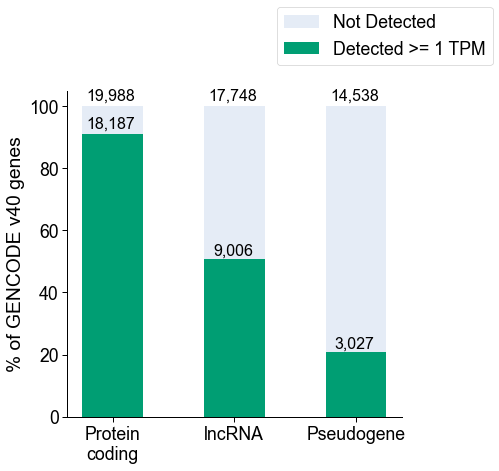

In [188]:
plt.figure(figsize=(6,6))
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c = get_ic_nov_colors()[0]['Known']
gray = get_not_det_color()

cats = [1]
c_dict, order = get_shade_colors(c, cats)
order.reverse()
biotypes = ['protein_coding', 'lncRNA', 'pseudogene']
b_dict = {'protein_coding': 'Protein\ncoding',
          'lncRNA': 'lncRNA',
          'pseudogene': 'Pseudogene'}

# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
def add_n(rects, label):
    ax = plt.gca()
    for rect in rects:
        # height = rect.get_height()
        x = rect.get_x()+rect.get_width()/2.1
        y = rect.get_height()*1.01
        ax.text(x,y,
                '{:,}'.format(label),
                ha='center', va='bottom', size=16)

def add_n_2(rects, label):
    ax = plt.gca()
    for rect in rects:
        # height = rect.get_height()
        x = rect.get_x()+rect.get_width()/2.1
        y = rect.get_height()*1.01
        ax.text(x,y,
                '{:,}'.format(label),
                ha='center', va='bottom', size=16)

for b in biotypes:
    x = b_dict[b]
    y = 0
    rects = plt.bar(x, [100], color=gray, width=0.5)
    # add total number of genes
    n = df.loc[(df.biotype_category == b)&(df.tpm_thresh==1), 'annot_counts'].tolist()[0]
    add_n(rects, n)

    for c in order:
        curr_y = df.loc[(df.biotype_category == b)&(df.tpm_thresh==c), 'perc'].tolist()[0]
        rects = plt.bar(x, [curr_y], color=c_dict[c], width=0.5)
        if c == 1:
            n = df.loc[(df.biotype_category == b)&(df.tpm_thresh==1), 'obs_counts'].tolist()[0]
            add_n_2(rects, n)
            print(b)
            print(curr_y)
            print(df.loc[(df.biotype_category == b)&(df.tpm_thresh==c), ['obs_counts', 'annot_counts']])
            print()
        y = y+curr_y
     
    
leg_labels = ['Not Detected', 'Detected >= 1 TPM']
plt.legend(leg_labels, bbox_to_anchor=(.6, 1.05))
ax = plt.gca()
leg = ax.get_legend()
plt.ylabel('% of GENCODE v40 genes')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('figures/known_gene_det.pdf', dpi=500, bbox_inches='tight')
plt.savefig('figures/known_gene_det.png', dpi=500, bbox_inches='tight')

## Panel B -- gene detection of novel genes

In [128]:
# just use the figure from the supplement for now? 

## Panel C -- transcript detection for known and novel transcripts

In [190]:
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset,
               species='human',
               h5=cerberus_h5)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 209819


In [191]:
df = df.reset_index()
for feat in ['tss', 'ic', 'tes']:
    df = add_feat(df, col='annot_transcript_id', kind=feat)
    feat_df = get_ca_table(cerberus_h5, feat)
    feat_df = feat_df[['Name', 'novelty']]
    feat_df.rename({'novelty': '{}_novelty'.format(feat),
                    'Name': feat}, axis=1, inplace=True)
    df = df.merge(feat_df, how='left', on=feat)

df = df[['annot_transcript_id', 'tss_novelty', \
         'ic_novelty', 'tes_novelty']].groupby(['tss_novelty', \
         'ic_novelty', \
         'tes_novelty']).count()
df = df.reset_index()

In [192]:
# groupby EC novelty
df = df[['ic_novelty', 'annot_transcript_id']].groupby('ic_novelty').sum().reset_index().rename({'annot_transcript_id':'# transcripts'}, axis=1)

In [193]:
df.head()

,ic_novelty,# transcripts
0,ISM,15897
1,Known,136313
2,NIC,35869
3,NNC,21740


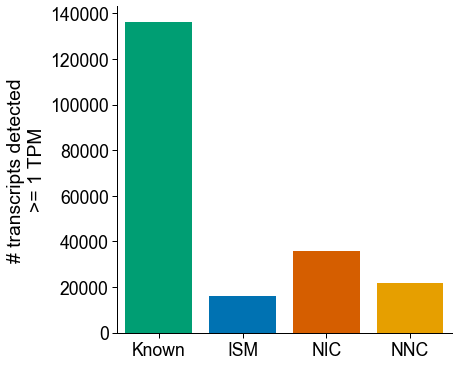

In [194]:
plt.figure(figsize=(6,6))
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_ic_nov_colors(cats=df.ic_novelty.unique().tolist())

assert list(set(df.ic_novelty.unique().tolist())) == list(set(c_dict.keys()))

ax = sns.barplot(df, y='# transcripts', x='ic_novelty',
            palette=c_dict, order=order,
            saturation=1)
ax.set(ylabel='# transcripts detected\n>= 1 TPM', xlabel='') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('figures/transcript_det.pdf', dpi=500)
plt.savefig('figures/transcript_det.png', dpi=500, bbox_inches='tight')

## Panel feature detection - known and novel, split by support

tss
Support sources:['encode_cage', 'fantom_cage', 'encode_rampage', 'gtex', 'pls', 'encode_procap', 'lrgasp_cage', 'pol2', 'ca_h3k4me3']
Calculating tss TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 73812
# tsss >= 1 tpm: 64913
Applying gene type and novelty subset
Number of tsss reported: 61664
156184
61664
ic
Support sources:['gtex']
Calculating ic TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 131409
Applying gene type and novelty subset
Number of ics reported: 128159
357068
128159
tes
Support sources:['pas', 'polya_atlas', 'gtex']
Calculating tes TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tess detected: 87189
# tess >= 1 tpm: 76035
Applying gene type and novelty subset
Number of tess reported: 72806
187005
72806


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


<Figure size 432x2160 with 0 Axes>

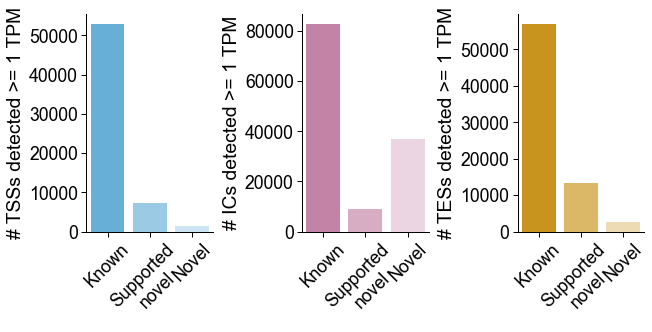

In [189]:
feats = ['tss', 'ic', 'tes']
ref_sources = [['v29', 'v40'],
               ['v29', 'v40'],
               ['v29', 'v40']]
support_sources = [['encode_cage', 'fantom_cage',
                       'encode_rampage', 'gtex', 'pls',
                       'encode_procap', 'lrgasp_cage', 'pol2', 'ca_h3k4me3'],
                   ['gtex'],
                   ['pas', 'polya_atlas', 'gtex']]

plt.figure(figsize=(6,6*5))
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

fig, axes = plt.subplots(1, len(feats), figsize=(10,4))
i = 0

for feat, ref_source, support_source in zip(feats, ref_sources, support_sources):
    print(feat)
    ax = axes[i]
    print(f'Support sources:{support_source}')
    # get detected features
    df = pd.read_csv(filt_ab, sep='\t')
    df, ids = get_tpm_table(df,
                            h5=cerberus_h5,
                            gene_subset=gene_subset,
                            min_tpm=min_tpm,
                            how=feat)

    # get these features from cerberus
    ca = cerberus.read(cerberus_h5)
    if feat == 'tss':
        ca_df = ca.tss
    elif feat == 'tes':
        ca_df = ca.tes
    elif feat == 'ic':
        ca_df = ca.ic
    print(len(ca_df.index))
    df = ca_df.loc[ca_df.Name.isin(ids)]
    print(len(df.index))


    # get T/F detection of each feat by each source
    df = upsetplot.from_memberships(df.source.str.split(','), data=df)
    df.reset_index(inplace=True)

    # which sources are observed, which are supported, and which are known
    sources = ca.get_sources(df)

    df['support'] = 'Novel'
    df['support_2'] = 'Novel'
    if support_source:
        df.loc[df[support_source].any(axis=1), 'support'] = 'Supported'
        df.loc[df[support_source].any(axis=1), 'support_2'] = 'Supported'
    df.loc[df[ref_source].any(axis=1), 'support'] = 'Known'
    df2 = df[['Name', 'support_2']]

    df = df[['Name', 'support']]
    df = df.groupby('support').count().reset_index()
    df.rename({'Name': 'counts'}, axis=1, inplace=True)


    df2 = df2.groupby('support_2').count().reset_index()
    df2.rename({'Name': 'counts'}, axis=1, inplace=True)
    
    
    df.loc[df.support=='Supported', 'support'] = 'Supported\nnovel'
    if feat == 'ic':
        c_key = 'splicing'
    else:
        c_key = feat
    temp_c_dict, order = get_sector_colors()
    c = temp_c_dict[c_key]
    order = ['Known', 'Supported\nnovel', 'Novel']
    c_dict, order = get_shade_colors(c, order)
    ax = sns.barplot(df, y='counts', x='support', 
                palette=c_dict, order=order, ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

    xlabel = ''
    ylabel = '# {}s detected >= 1 TPM'.format(feat.upper())

    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    i += 1

plt.subplots_adjust(wspace=0.7)

plt.savefig('figures/det_feats.png', dpi=500, layout='tight', bbox_inches='tight')

## Panel ?? - dotplot where size is # genes and color is sector

In [135]:
ca = cerberus.read(cerberus_h5)

In [143]:
gene_df, _, _ = get_gtf_info(how='gene', ver=ver, add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'biotype_category']]
gene_df.rename({'gid_stable': 'gid'}, axis=1, inplace=True)
ca.triplets = ca.triplets.merge(gene_df, how='left', on='gid')

In [146]:
df = ca.triplets.loc[(ca.triplets.source == 'obs_det')&\
                     (ca.triplets.biotype_category=='protein_coding')]

In [149]:
temp = df[['sector', 'gid']].groupby('sector').count().reset_index().rename({'gid':'n_genes'}, axis=1)
temp['total'] = temp.n_genes.sum()
temp['perc'] = (temp['n_genes']/temp['total'])*100
temp['x'] = [i for i in range(len(temp.index))]

In [150]:
c_dict, order = get_sector_colors()

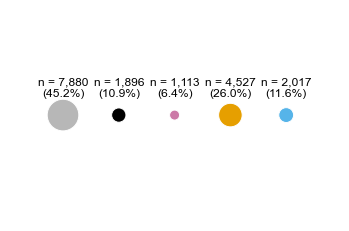

In [184]:
ax = sns.scatterplot(temp, y='total', x='x', hue='sector', 
                palette=c_dict, legend=False, size='n_genes', sizes=(100,1000))
plt.xlim(-1, 5)
for index, row in temp.iterrows():
    ax.text(row['x'],
            row['total']+150,
            f"n = {row['n_genes']:,}\n({row['perc']:.1f}%)",
            horizontalalignment='center',
            verticalalignment='bottom', fontsize=12, color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.set_xlabel('')
ax.set_ylabel('')
# plt.show()

plt.savefig('figures/n_genes_per_sector.png', dpi=500)

## Panel results for TSS and splicing high genes

In [196]:
ca = cerberus.read(cerberus_h5)

In [197]:
df = ca.triplets

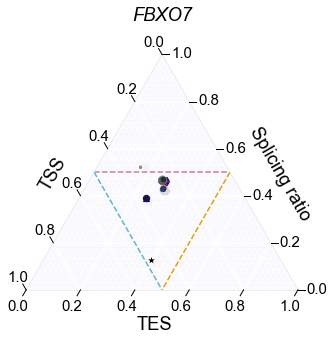

In [205]:
gene = 'FBXO7'
plot_sample_det_density_simplex(ca, gene)


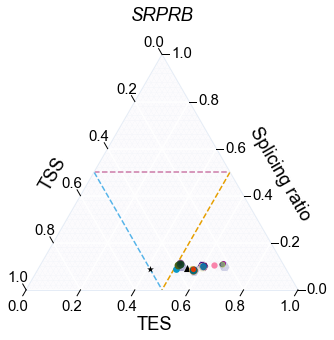

In [204]:
gene = 'SRPRB'
plot_sample_det_density_simplex(ca, gene)

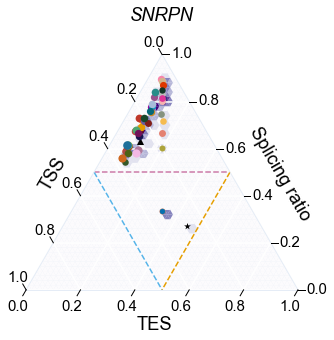

In [195]:
gene = 'SNRPN'
plot_sample_det_density_simplex(ca, gene)

In [200]:
df.loc[(df.gname==gene)&(df.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
3977,sample_det,ENSG00000128739,2.0,1.0,21.0,21.0,14.000000,0.117647,0.058824,0.823529,splicing,SNRPN,hffc6,174.496643
17739,sample_det,ENSG00000128739,4.0,1.0,15.0,16.0,6.000000,0.363636,0.090909,0.545455,splicing,SNRPN,colon,53.618965
32382,sample_det,ENSG00000128739,2.0,1.0,17.0,17.0,11.333333,0.139535,0.069767,0.790698,splicing,SNRPN,hl60_m1_12hr,249.951248
44103,sample_det,ENSG00000128739,3.0,1.0,15.0,16.0,7.500000,0.260870,0.086957,0.652174,splicing,SNRPN,ovary,273.958344
71577,sample_det,ENSG00000128739,2.0,1.0,16.0,16.0,10.666667,0.146341,0.073171,0.780488,splicing,SNRPN,hl60_m2_24hr,211.246368
95869,sample_det,ENSG00000128739,3.0,1.0,21.0,21.0,10.500000,0.206897,0.068966,0.724138,splicing,SNRPN,caco2,268.984314
108769,sample_det,ENSG00000128739,2.0,1.0,16.0,16.0,10.666667,0.146341,0.073171,0.780488,splicing,SNRPN,huvec,175.396027
121777,sample_det,ENSG00000128739,4.0,1.0,34.0,35.0,13.600000,0.215054,0.053763,0.731183,splicing,SNRPN,heart,429.747192
139123,sample_det,ENSG00000128739,2.0,1.0,16.0,16.0,10.666667,0.146341,0.073171,0.780488,splicing,SNRPN,gm12878,84.168144
153414,sample_det,ENSG00000128739,5.0,1.0,23.0,28.0,7.666667,0.365854,0.073171,0.560976,splicing,SNRPN,wtc11,802.642029


In [201]:
gene='APOL1'
df.loc[(df.gname==gene)&(df.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
1513,sample_det,ENSG00000100342,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,APOL1,hffc6,1.282133
14728,sample_det,ENSG00000100342,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,splicing,APOL1,colon,27.771866
30332,sample_det,ENSG00000100342,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,APOL1,hl60_m1_12hr,2.168944
41184,sample_det,ENSG00000100342,1.0,2.0,8.0,9.0,5.333333,0.120000,0.240000,0.640000,splicing,APOL1,ovary,40.963261
81001,sample_det,ENSG00000100342,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,splicing,APOL1,calu3,130.971039
106312,sample_det,ENSG00000100342,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,APOL1,huvec,8.893411
118704,sample_det,ENSG00000100342,1.0,1.0,8.0,8.0,8.000000,0.100000,0.100000,0.800000,splicing,APOL1,heart,8.357699
136544,sample_det,ENSG00000100342,1.0,2.0,9.0,10.0,6.000000,0.111111,0.222222,0.666667,splicing,APOL1,gm12878,45.255466
175803,sample_det,ENSG00000100342,1.0,1.0,3.0,3.0,3.000000,0.200000,0.200000,0.600000,splicing,APOL1,brain,5.104954
205180,sample_det,ENSG00000100342,1.0,1.0,6.0,6.0,6.000000,0.125000,0.125000,0.750000,splicing,APOL1,hepg2,16.661583


In [202]:
gene='JUND'
df.loc[(df.gname==gene)&(df.source=='sample_det')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
4103,sample_det,ENSG00000130522,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,JUND,hffc6,6.395195
17903,sample_det,ENSG00000130522,2.0,1.0,2.0,3.0,1.333333,0.461538,0.230769,0.307692,mixed,JUND,colon,303.964172
32490,sample_det,ENSG00000130522,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,JUND,hl60_m1_12hr,124.109802
44261,sample_det,ENSG00000130522,2.0,1.0,2.0,3.0,1.333333,0.461538,0.230769,0.307692,mixed,JUND,ovary,174.427567
59159,sample_det,ENSG00000130522,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,JUND,hct116,609.997009
71693,sample_det,ENSG00000130522,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,JUND,hl60_m2_24hr,123.146011
83592,sample_det,ENSG00000130522,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,JUND,calu3,85.700348
96005,sample_det,ENSG00000130522,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,JUND,caco2,130.533859
108903,sample_det,ENSG00000130522,2.0,1.0,1.0,2.0,0.666667,0.545455,0.272727,0.181818,tss,JUND,huvec,210.197021
121949,sample_det,ENSG00000130522,2.0,1.0,2.0,3.0,1.333333,0.461538,0.230769,0.307692,mixed,JUND,heart,258.830383


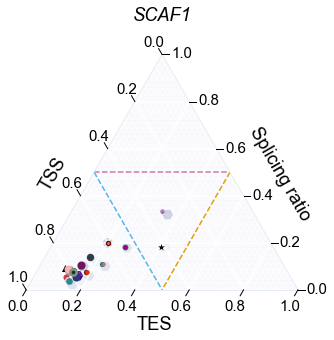

In [206]:
gene = 'SCAF1'
plot_sample_det_density_simplex(ca, gene)

Read in graph from ../../proc_revisions/data/human/lr/swan/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 209819
Found 51 total samples


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/plotting.py:1913: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


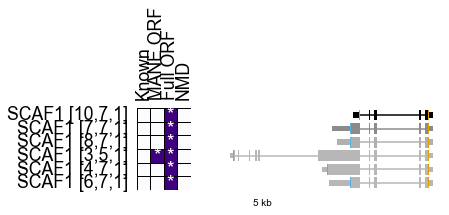

In [208]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        gene,
                        obs_col,
                        'brain',
                        f'figures/brain_scaf1_isos_browser.pdf',
                        major=False)

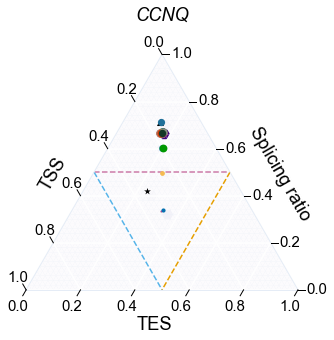

In [209]:
gene = 'CCNQ'
plot_sample_det_density_simplex(ca, gene)

Read in graph from ../../proc_revisions/data/human/lr/swan/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 209819
Found 51 total samples


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/plotting.py:1913: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


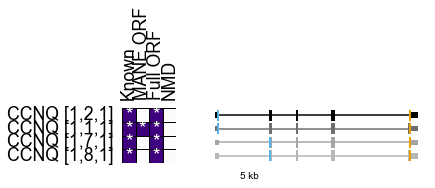

In [211]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        gene,
                        obs_col,
                        'brain',
                        f'figures/brain_ccnq_isos_browser.pdf',
                        major=False)